# Restez Livres - Revue Business
"Rester livres" s'est d'abord développée dans une grande ville de France, avec plusieurs magasins, jusqu'à décider d'ouvrir une boutique en ligne. Son approche de la vente de livres en ligne, basée sur des algorithmes de recommandations, lui a valu un franc succès !

## Sommaire <a id="Sommaire"></a>
[Travaux préliminaires](#Titre1)
<br/>
<br/> [I - Nettoyage et compréhension des données](#Titre2)
<br/> [A - Nettoyage du Dataframe Produits](#Titre2A)
<br/> [B - Nettoyage du Dataframe Clients](#Titre2B)
<br/> [C - Nettoyage du Dataframe Transactions](#Titre2C)
<br/>
<br/> [II - Compilation des données et analyses](#Titre3)
<br/> [A - Compilation des Dataframes](#Titre3A)
<br/> [B - Analyse du Dataframe compilé](#Titre3B)
<br/> [C - Courbe de Lorenz et indice de Gini](#Titre3C)
<br/>
<br/> [III - Corrélations](#Titre4)
<br/> [A - 2 variables qualitatives : Test du KHIDEUX](#Titre4A)
<br/> [B - 1 variable qualitative et 1 variable quantitative : ANOVA](#Titre4B)
<br/> [C - 2 variables quantitatives : Coefficient de Pierson](#Titre4C)

## Travaux préliminaires <a id="Titre1"></a>

### A - Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import seaborn as sb
import datetime as dt
import scipy.stats as st

 ### B - Lieu d'enregistrement des données et importation des Dataframes

In [2]:
%cd C:\Users\Thaad\Desktop\Python\Open Classroom

C:\Users\Thaad\Desktop\Python\Open Classroom


In [3]:
Produits = pd.read_csv('products.csv')
Clients = pd.read_csv('customers.csv')
Transactions = pd.read_csv('transactions.csv')

### C - Configuration du Notebook Jupyter

In [4]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### D - Fonction est_vide

In [5]:
def empty_val(df):
    data = df.copy()
    for column in df.columns:
        data = data[data[column].astype(str).str.len() < 1]
    return data

### E - Fonction eta_carre

In [6]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

[Retour au Sommaire](#Sommaire)

## I - Nettoyage et compréhension des données <a id="Titre2"></a>
Nettoyage et mise en forme des données et identification, si applicable, des valeurs manquantes ou aberrantes.

### A - Nettoyage du Dataframe Produits <a id="Titre2A"></a>

#### 1 - Compréhension du Dataframe

Afin d'obtenir une meilleure compréhension de nos données, nous avons analysé chaque colonne pour en comprendre leur contenu.

In [7]:
Produits.info()
Produits.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


- Restez Livres vend 3287 types de produits.
- Chaque produit possède une catégorie et un prix.

In [8]:
empty_val(Produits)

,id_prod,price,categ


- Aucune ligne ne présente au moins une valeur vide.

#### 2 - Analyse de la colonne Prix
Nous allons analyser la colonne Prix afin d'obtenir une meilleure compréhension de celle-ci.

In [9]:
Produits.price.describe()

count    3287.000000
mean       21.856641
std        29.847908
min        -1.000000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: price, dtype: float64

- Le prix moyen des produits est de 22 euros.
- Le prix median est de 13 euros.
- Le produit le plus cher est de 300 euros.
- Le produit le moins cher est de -1 euros.
<br/>
<br/> Nous allons analyser les produits ayant un prix négatif pour comprendre leurs origines.

In [10]:
ProduitsNégatif = Produits[Produits['price'] < 0]
ProduitsNégatif

,id_prod,price,categ
731,T_0,-1.0,0


L'ID Produit est incohérent, le prix est négatif. **Nous allons supprimer cette valeur aberrante**.

In [11]:
Produits = Produits[Produits['price'] > 0]

#### 3 - Analyse de la colonne Catégorie
Nous allons analyser la colonne Catégorie afin d'obtenir une meilleure compréhension de celle-ci.

In [12]:
Produits.categ.describe()

count    3286.000000
mean        0.370359
std         0.615446
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: categ, dtype: float64

- Le format de la colonne Catégorie n'est pas adéquat pour une variable qualitative.
<br/> Nous allons la convertir en chaine de caractère.
- La catégorie moyenne est de 0.37 pour une catégorie médiane à 0. Nous en concluons que la catégorie la plus réprésentée est la catégorie 0.
- La plus grande catégorie est la 2 et la plus petite la 0.
<br/>
<br/> Nous allons également analyser le nombre de catégorie.

In [13]:
Produits.categ = Produits.categ.astype('str')
Produits['categ'].unique()

array(['0', '1', '2'], dtype=object)

- Il existe 3 catégories : 0, 1 et 2 
<br/>
<br/> Nous allons maintenant analyser les catégories en fonction des prix de ventes à l'aide d'un diagramme en moustache.

Text(0.5, 1.0, 'Prix des produits par catégories')

<Figure size 216x2880 with 0 Axes>

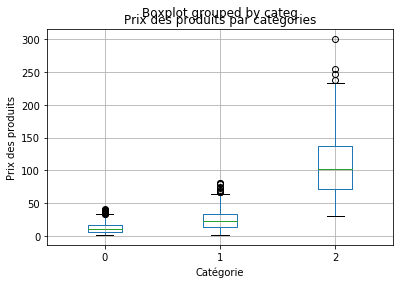

In [14]:
pp.figure(figsize=(3,40))
Produits.boxplot(column=['price'], by=['categ'])
pp.xlabel('Catégorie')
pp.ylabel('Prix des produits')
pp.title("Prix des produits par catégories")

- Les catégories semblent s'apparenter à différentes gammes de prix.
- La catégorie la plus réprésentée dans le catalogue est la catégorie 0 qui est la catégorie la moins chère.
- Les catégories 1 et 2 sont plus chères que la 0, la 2 étant la plus élevée.

#### 4 - Analyse de la colonne ID Produits

In [15]:
Produits.head(3)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


Nous constatons sur les trois premières lignes ci-dessus que les premiers numéros de l'ID Produit correspond à la catégorie du même produit. Nous avons vérifié cela par un test de cohérence.
<br/> Ce postulat n'était pas respecté avec le produit possédant un prix négatif. Il est pertinent de valider ce postulat.

In [16]:
Produits['LeftProduits'] = Produits['id_prod'].str[:1]
Produits['Cohérence'] = (Produits['LeftProduits']==Produits['categ'])
Produits['Cohérence'].unique()

array([ True])

- Nous constatons que les ID Produits commencent bien tous par leur catégorie.

In [17]:
Produits.drop(columns = ['LeftProduits','Cohérence'], inplace = True)

[Retour au Sommaire](#Sommaire)

### B - Nettoyage du Dataframe Clients <a id="Titre2B"></a>

#### 1 - Compréhension du Dataframe

Afin d'obtenir une meilleure compréhension de nos données, nous avons analysé chaque colonne pour en comprendre leur contenu.

In [18]:
Clients.info()
Clients.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984


- Chaque client possède un ID, un sexe et une année de naissance.
- Les ID clients semblent commencer par c_.
<br/>
<br/> Nous allons convertir l'année de naissance en âge du client.

In [19]:
empty_val(Clients)

,client_id,sex,birth


- Aucune ligne ne présente au moins une valeur vide.

#### 2 - Analyse de la colonne Naissance/Age

In [20]:
Clients['age'] = 2022 - Clients['birth']
Clients.drop(columns = ['birth'], inplace = True)
Clients.age.describe()

count    8623.000000
mean       43.719123
std        16.919535
min        18.000000
25%        30.000000
50%        43.000000
75%        56.000000
max        93.000000
Name: age, dtype: float64

- L'âge moyen des clients est de 44 ans.
- L'âge médian des clients est de 43 ans.
- Le client le moins agé a 18 ans.
- Le client le plus agé a 93 ans.
<br/>
<br/> L'âge moyen et l'âge médian des client est assez proche. La distribution semble symétrique.
<br/> Pour faciliter nos analyses futures, nous allons créer des catégories d'âge.

In [21]:
age1 = Clients.copy()
age1 = Clients[Clients['age']<31]
age1["trancheage"] = "18-30 ans"

agebis = Clients[Clients['age']>30]
age2 = agebis.copy()
age2 = agebis[agebis['age']<44]
age2["trancheage"] = "31-43 ans"

agebis = Clients[Clients['age']>43]
age3 = agebis.copy()
age3 = agebis[agebis['age']<57]
age3["trancheage"] = "44-56 ans"

agebis = Clients[Clients['age']>56]
age4 = agebis.copy()
age4 = agebis[agebis['age']<70]
age4["trancheage"] = "57-69 ans"

agebis = Clients[Clients['age']>69]
age5 = agebis.copy()
age5 = agebis[agebis['age']<83]
age5["trancheage"] = "70-82 ans"

age6 = Clients.copy()
age6 = Clients[Clients['age']>82]
age6["trancheage"] = "83 ans et plus"

C:\Users\Thaad\anaconda3bis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Thaad\anaconda3bis\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Thaad\anaconda3bis\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [22]:
Clients=pd.concat([age1, age2, age3, age4, age5, age6])
Clients.info()
Clients.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8623 entries, 5 to 8543
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_id   8623 non-null   object
 1   sex         8623 non-null   object
 2   age         8623 non-null   int64 
 3   trancheage  8623 non-null   object
dtypes: int64(1), object(3)
memory usage: 336.8+ KB


,client_id,sex,age,trancheage
5,c_415,m,29,18-30 ans
9,c_6866,m,29,18-30 ans
13,c_2998,m,19,18-30 ans


In [23]:
NombreClients = Clients.groupby(['trancheage'],as_index = True ).client_id.count()

Text(0.5, 1.0, "Nombre de clients par tranche d'âge")

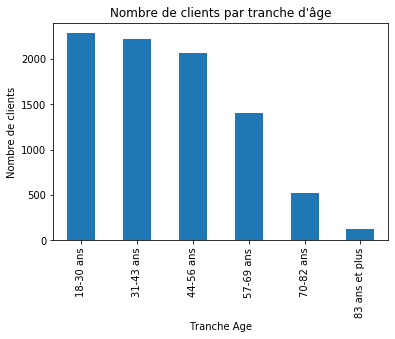

In [24]:
NombreClients.plot(kind = 'bar')
pp.xlabel('Tranche Age')
pp.ylabel('Nombre de clients')
pp.title("Nombre de clients par tranche d'âge")

- Le nombre de clients par tranches d'âge est assez stable jusqu'à 56 ans.
- A partir de 56 ans, le nombre de clients décroit.

#### 3 - Analyse de la colonne Sexe

Nous allons tout d'abord tester la composition de la colonne Sexe.

In [25]:
Clients.sex.unique()

array(['m', 'f'], dtype=object)

Nos clients sont soit des hommes, soit des femmes. Nous allons analyser la répartition de ceux-ci en nombre.

Text(0.5, 1.0, 'Répartion H/F des clients')

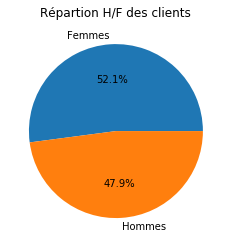

In [26]:
pp.pie(Clients['sex'].value_counts(), labels = ['Femmes', 'Hommes'], autopct = '%1.1f%%')
pp.title("Répartion H/F des clients")

- 52% de nos clients sont des femmes
- 48% de nos clients sont des hommes
<br/>
<br/> Nous allons  affiner cette analyse en rajoutant comme dimension les tranches d'âge.

In [27]:
Trancheagesexe = Clients.groupby(['trancheage', 'sex'],as_index = True ).client_id.count()

Text(0.5, 1.0, "Nombre de clients par tranche d'age et par sexe")

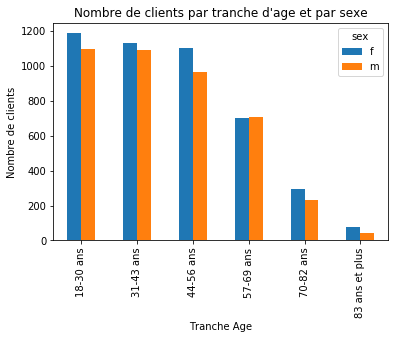

In [28]:
Trancheagesexe.unstack().plot(kind = 'bar')
pp.xlabel('Tranche Age')
pp.ylabel('Nombre de clients')
pp.title("Nombre de clients par tranche d'age et par sexe")

- Le sexe des clients est bien réparti au sein de chaque tranche d'âge.

#### 4 - Analyse de la colonne ID CLient

In [29]:
Clients.head(3)

,client_id,sex,age,trancheage
5,c_415,m,29,18-30 ans
9,c_6866,m,29,18-30 ans
13,c_2998,m,19,18-30 ans


Les ID Clients semblent débuter par c_, nous allons investiguer pour savoir si certains éléments semblent aberrants.

In [30]:
Clients['client_id'].str[:2].unique()

array(['c_', 'ct'], dtype=object)

Il existe des ID CLients commençant par ct, nous allons investiguer ceux-ci afin de définir si ce sont des anomalies ou non.

In [31]:
Clientsct = Clients[Clients['client_id'].str[:2] == 'ct']
Clientsct

,client_id,sex,age,trancheage
2735,ct_0,f,21,18-30 ans
8494,ct_1,m,21,18-30 ans


Ces deux clients semblent correctement complétés, **nous choississons de les conserver**.

[Retour au Sommaire](#Sommaire)

### C - Nettoyage du Dataframe Transaction <a id="Titre2C"></a>

#### 1 - Compréhension du Dataframe

Afin d'obtenir une meilleure compréhension de nos données, nous avons analysé chaque colonne pour en comprendre leur contenu.

In [32]:
Transactions.info()
Transactions.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270


- Chaque transaction possède un ID, un produit, une date et un client lié.
- Les ID clients semblent commencer par 0_, 1_ ou 2_ comme vu précedemment dans notre analyse du DF Produits.
- Les ID produits semblent commencer par c_ comme vu précedemment dans notre analyse du DF Clients.
- Les ID sessions semblent commencer par s_.
<br/>
<br/> Le format de la date semble difficillement exploitable.

In [33]:
empty_val(Transactions)

,id_prod,date,session_id,client_id


- Aucune ligne ne présente au moins une valeur vide

#### 2 - Analyse de la colonne ID CLient

In [34]:
Transactions['client_id'].str[:2].unique()

array(['c_', 'ct'], dtype=object)

Il existe des ID Clients commençant par ct, nous allons investiguer ceux-ci afin de définir si ce sont des anomalies ou non.

In [35]:
Transactionsct = Transactions[Transactions['client_id'].str[:2] == 'ct']
Transactionsct.describe()

,id_prod,date,session_id,client_id
count,200,200,200,200
unique,1,39,1,2
top,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0
freq,200,13,200,106


In [36]:
Transactionsct.head(3)

,id_prod,date,session_id,client_id
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1


- 200 ID clients débutent par ct (Il n'en existe que 2 comme vu plus haut dans le DF CLients à savoir ct_0 et ct_0).
- Ces opérations possèdent le même ID Session : s_0.
- L'unique ID Produit de ces opérations est le T_0 qui était notre produit ayant pour prix : -1 qui a été supprimé plus haut.
- La date débute par test.
<br/>
<br/>Ces valeurs sont des valeurs aberrantes, **nous choississons de les supprimer**.
<br/>Par souci de cohérence vu qu'aucune de ces valeurs ne sera présente dans le DF Transactions, nous allons également supprimer ces deux ID clients du DF CLients.

In [37]:
Transactions = Transactions[Transactions['client_id'].str[:2] == 'c_']
Clients = Clients[Clients['client_id'].str[:2] == 'c_']

#### 3 - Analyse de la colonne ID Session

In [38]:
Transactions['session_id'].str[:2].unique()

array(['s_'], dtype=object)

-Tous les ID sessions débutent bien par s_

#### 4 - Analyse de la colonne ID Produit

In [39]:
Transactions['id_prod'].str[:2].unique()

array(['0_', '2_', '1_'], dtype=object)

-Tous les ID sessions dévutent bien par 0_, 1_ ou 2_.

#### 5 - Analyse de la colonne Date

Le format de la date n'est pas exploitable, nous allons le retraiter et créer une colonne Mois.

In [40]:
Transactions['date']= pd.to_datetime(Transactions['date'], format='%Y/%m/%d')
Transactions['date'] = Transactions['date'].map(lambda x:x.strftime('%Y-%m-%d'))
Transactions['date']= pd.to_datetime(Transactions['date'], format='%Y/%m/%d')
Transactions['Mois']=Transactions['date'].map(lambda x:x.strftime('%m'))

In [41]:
Transactions.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
Mois                  object
dtype: object

In [42]:
Transactions.head(3)

,id_prod,date,session_id,client_id,Mois
0,0_1483,2021-04-10,s_18746,c_4450,04
1,2_226,2022-02-03,s_159142,c_277,02
2,1_374,2021-09-23,s_94290,c_4270,09


La date est désormais exploitable dans nos analyses.

[Retour au Sommaire](#Sommaire)

## II - Compilation des données et analyses <a id="Titre3"></a>
Après avoir compilé nos trois Dataframes, nous allons les analyser pour mieux comprendre l'activité de "Rester Livres".

### A - Compilation des DataFrames <a id="Titre3A"></a>

#### 1 - Compilation

In [43]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336816 entries, 0 to 337015
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     336816 non-null  object        
 1   date        336816 non-null  datetime64[ns]
 2   session_id  336816 non-null  object        
 3   client_id   336816 non-null  object        
 4   Mois        336816 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 15.4+ MB


Nous avons un total de 336 816 transactions sur la période.
<br/> En compilant nos données nous allons :
- Obtenir un Dataframe récapitulatif de toutes nos transactions ayant un ID client et un ID produit reconnu.
- Obtenir un Dataframe incluant toutes les transactions avec un ID produit/ID client non reconnu.
- Connaitre les produits qui ne se sont pas vendus sur la période.
- Connaitre les clients qui n'ont pas acheté de produits sur la période.

In [44]:
Concat1 = pd.merge(Transactions, Clients, on = 'client_id', how = 'inner') 
Compil = pd.merge (Concat1,Produits,on = 'id_prod', how = 'inner')

In [45]:
Compil.head(3)

,id_prod,date,session_id,client_id,Mois,sex,age,trancheage,price,categ
0,0_1483,2021-04-10,s_18746,c_4450,04,f,45,44-56 ans,4.99,0
1,0_1483,2021-12-27,s_140787,c_5433,12,f,41,31-43 ans,4.99,0
2,0_1483,2021-10-27,s_110736,c_857,10,m,37,31-43 ans,4.99,0


In [46]:
Compil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336713 entries, 0 to 336712
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     336713 non-null  object        
 1   date        336713 non-null  datetime64[ns]
 2   session_id  336713 non-null  object        
 3   client_id   336713 non-null  object        
 4   Mois        336713 non-null  object        
 5   sex         336713 non-null  object        
 6   age         336713 non-null  int64         
 7   trancheage  336713 non-null  object        
 8   price       336713 non-null  float64       
 9   categ       336713 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 28.3+ MB


Nous comprenons que 103 transactions ne possèdent pas un ID client ou produit reconnu dans notre base de données.
Nous allons investiguer. Nous commençons à investiguer les codes produits non reconnus.

#### 2 - ID produit/client non reconnu

In [47]:
TransactionsP = pd.merge (Transactions,Produits,on = 'id_prod', how = 'left')
TransactionsP = TransactionsP[pd.isnull(TransactionsP['categ'])]

In [48]:
TransactionsP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 6231 to 336020
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_prod     103 non-null    object        
 1   date        103 non-null    datetime64[ns]
 2   session_id  103 non-null    object        
 3   client_id   103 non-null    object        
 4   Mois        103 non-null    object        
 5   price       0 non-null      float64       
 6   categ       0 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 6.4+ KB


Nous avons retrouvé nos 103 transactions qui ont été retirées de notre Dataframe lors de la compilation. Nous étudions les produits qui sont concernés.

In [49]:
TransactionsP.id_prod.unique()

array(['0_2245'], dtype=object)

Il s'agit du produit 0_2245. Le prix moyen de la catégorie 0 est de 10-15 euros soit un impact de 1500 euros sur les ventes totales. Nous supprimons ce produit de notre Dataframe car sa valeur est peu significative.
Par déduction, aucun ID client non reconnu.

#### 3 - Produits non vendus sur l'année

In [50]:
ProduitsNV = pd.merge (Transactions,Produits,on = 'id_prod', how = 'right')
ProduitsNV = ProduitsNV[pd.isnull(ProduitsNV['session_id'])]

In [51]:
ProduitsNV.describe()

,price
count,22.000000
mean,36.285000
std,55.753603
min,0.800000
25%,2.990000
50%,21.485000
75%,30.112500
max,220.990000


Il existe 22 produits qui n'ont pas été vendus sur l'année. Nous analysons ensuite à quelle catégorie ils appartiennent.

Text(0.5, 1.0, 'Nombre de produits invendu par catégorie')

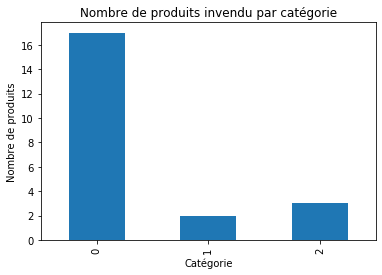

In [52]:
ProduitsNV = ProduitsNV.groupby(['categ'],as_index = True ).id_prod.count()
ProduitsNV.plot(kind = 'bar')
pp.xlabel('Catégorie')
pp.ylabel('Nombre de produits')
pp.title("Nombre de produits invendu par catégorie")

- Ce sont principalement des produits de la catégorie 0 qui sont invendus sur la période.
- Il convient de supprimer ces produits de notre DF Produits s'ils ne sont plus en vente.
- Nous pourrions lancer des campagnes publicitaires sur ces produits invendus.

#### 4 - Clients qui n'ont pas achetés de produits sur l'année

In [53]:
ClientsPA = pd.merge (Transactions,Clients,on = 'client_id', how = 'right')
ClientsPA = ClientsPA[pd.isnull(ClientsPA['session_id'])]

In [54]:
ClientsPA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 336816 to 336836
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_prod     0 non-null      object        
 1   date        0 non-null      datetime64[ns]
 2   session_id  0 non-null      object        
 3   client_id   21 non-null     object        
 4   Mois        0 non-null      object        
 5   sex         21 non-null     object        
 6   age         21 non-null     int64         
 7   trancheage  21 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.5+ KB


Il existe 21 clients qui n'ont pas acheté sur l'année. Nous analysons ensuite à quelle tranche d'âge ils appartiennent.

Text(0.5, 1.0, "Nombre de clients qui n'ont pas acheté sur l'année par tranche d'âge")

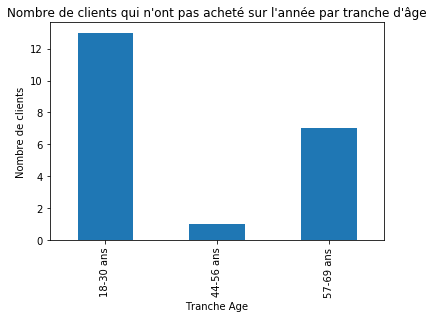

In [55]:
ClientsPA = ClientsPA.groupby(['trancheage'],as_index = True ).client_id.count()
ClientsPA.plot(kind = 'bar')
pp.xlabel('Tranche Age')
pp.ylabel('Nombre de clients')
pp.title("Nombre de clients qui n'ont pas acheté sur l'année par tranche d'âge")

- Il conviendrait d'enquêter auprès des clients entre 18 et 30 ans des raisons qui les ont poussés à ne pas renouveler leurs achats afin de tenter de fidéliser cette tranche d'âge.
- Les tranches d'âge entre 44 et 69 ans sont celles où le nombre de clients commence à décroitre, nous pourrions chercher à comprendre ce qui motive cette tendance.

[Retour au Sommaire](#Sommaire)

### B - Analyse du Dataframe compilé <a id="Titre3B"></a>

In [56]:
Compil.price.sum()

5796577.77

Le chiffre d'affaire sur la période est de 5 796 577.77 euros. Mais comment se décompose-t-il ?

#### 1 - Revue des ventes par genre sur la période

Nous allons analyser les ventes sur la période par genre.

Text(0.5, 1.0, "Evolution du chiffre d'affaire par jour par genre")

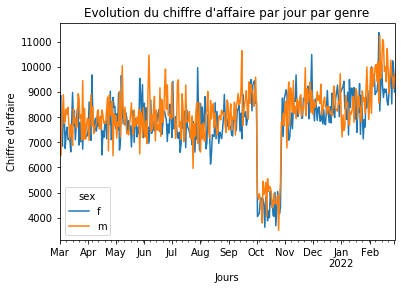

In [57]:
CA_jour = Compil.groupby(['date', 'sex']).price.sum()
CA_jour.unstack().plot(kind = 'line')
pp.xlabel('Jours')
pp.ylabel("Chiffre d'affaire")
pp.title("Evolution du chiffre d'affaire par jour par genre")

- Les montants sur le mois d'octobre semble étonnant, nous allons investiguer le nombre de ventes sur la période pour affiner nos conclusions.
- Pas de saisonnalité mise en évidence à la lecture de ce graphique hormis une lègère hausse des ventes en février. Nous n'avons pas assez de périodes à analyser pour conclure sur une hausse des ventes récurrente sur le mois de fin de période.
- Nous constatons une tendance à la hausse sur la période analysée (Il serait préférable d'analyser plus de périodes pour conclure sur une croissance).

Text(0.5, 1.0, 'Evolution du nombre de ventes par jour par genre')

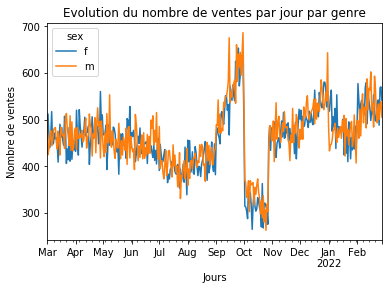

In [58]:
CA_jour = Compil.groupby(['date', 'sex']).price.count()
CA_jour.unstack().plot(kind = 'line')
pp.xlabel('Jours')
pp.ylabel("Nombre de ventes")
pp.title("Evolution du nombre de ventes par jour par genre")

- Le creux au mois d'octobre se confirme sur les quantités vendues également. Le pic de vente au mois de septembre pourrait expliquer qu'en octobre le nombre de vente soit plus faible.
- En excluant le mois d'octobre, nous avons plus vendu lors de la seconde moitié de période que lors de la première. Cela nous conforte dans le fait qu'il y a eu une croissance sur la période. Néanmoins, ces fortes ventes semblent toucher des produits de catégorie 1 ou 2.

#### 2 - Revue des ventes par Catégorie sur la période

Nous allons analyser les ventes sur la périodes par Catégorie.

Text(0.5, 1.0, "Evolution du chiffre d'affaires par jour par catégorie")

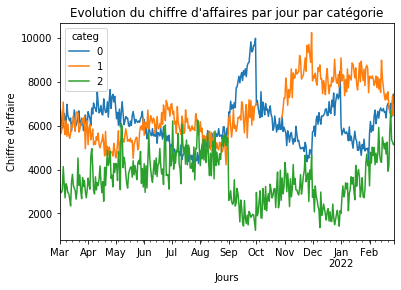

In [59]:
CA_categ = Compil.groupby(['date','categ']).price.sum()
CA_categ.unstack().plot(kind = 'line')
pp.xlabel('Jours')
pp.ylabel("Chiffre d'affaire")
pp.title("Evolution du chiffre d'affaires par jour par catégorie")

- La croissance que nous constatons sur la seconde période est soutenue par les ventes de la catégorie 1 en hausse en moitié de seconde période.
- Il y a eu une diminution des ventes de la catégorie 2 sur cette même période, néanmoins l'activité a repris en fin d'année pour revenir à un niveau plus standard.
- Le pic de vente en quantité du mois de septembre provient des ventes de la catégorie 0. Cette période est peut-être un moment propice à la promotion pour ce produit. A noter que cette hausse est tombée au même moment que la diminution des ventes de la catégorie 2 plus chère. Y a-t-il des clients qui ont migré sur une offre moins chère en septembre ?
<br/>
<br/>Comme pour la précédente analyse nous allons étudier le volume de vente en quantité par catégorie pour obtenir un autre axe de lecture.

Text(0.5, 1.0, 'Evolution du nombre de ventes par jour par catégorie')

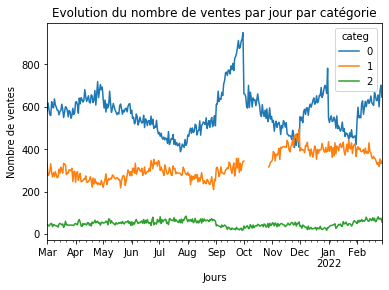

In [60]:
CA_categ = Compil.groupby(['date','categ']).price.count()
CA_categ.unstack().plot(kind = 'line')
pp.xlabel('Jours')
pp.ylabel("Nombre de ventes")
pp.title("Evolution du nombre de ventes par jour par catégorie")

- Nous constatons une elasticité Prix unitaire/Volume positive. En effet, plus un produit fait partie d'une gamme de prix élevés, moins il est vendu.
- Le pic de vente de septembre ne semble pas provenir d'un changement dans le comportement des acheteurs de la catégorie 2 qui seraient passé sur une offre moins chère.
- Il existe un trou dans les ventes sur le mois d'octobre 2021 sur la catégorie 1. Nous allons investiguer la période exacte en cause et la supprimer pour ne pas fausser nos analyses de corrélations futures.

In [61]:
Octobre1 = Compil.groupby(['categ','Mois', 'date'],as_index = False ).price.sum()
Octobre1 = Octobre1[Octobre1['Mois'] == '10']
Octobre1 = Octobre1[Octobre1['categ'] == '1']
Octobre1

,categ,Mois,date,price
638,1,10,2021-10-01,7003.79
639,1,10,2021-10-28,6317.99
640,1,10,2021-10-29,6425.18
641,1,10,2021-10-30,6753.69
642,1,10,2021-10-31,7261.67


Nous n'avons dans notre DF aucune vente pour la catégorie 1 entre le 02/10/2021 et le 27/10/2021. **Nous choisissons de supprimer le mois d'octobre de notre analyse**.

In [62]:
Base = Compil[Compil['Mois'] != '10']

#### 3 - Revue des ventes par tranche d'âge

Nous allons analyser les ventes sur la périodes par genre.

Text(0.5, 1.0, "Evolution du chiffre d'affaire par tranche d'âge")

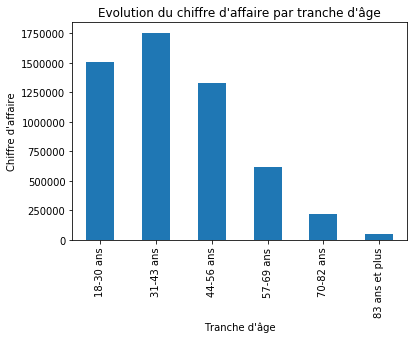

In [63]:
CA_jour = Base.groupby(['trancheage']).price.sum()
CA_jour.plot(kind = 'bar')
pp.xlabel("Tranche d'âge")
pp.ylabel("Chiffre d'affaire")
pp.title("Evolution du chiffre d'affaire par tranche d'âge")

Text(0.5, 1.0, "Evolution du nombre de ventes par tranche d'âge")

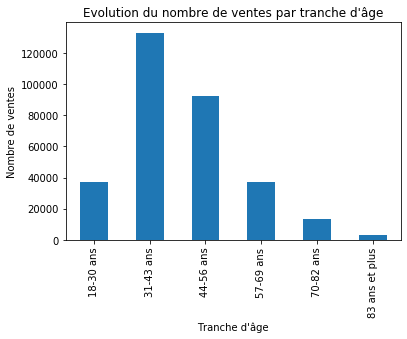

In [64]:
CA_jour = Base.groupby(['trancheage']).price.count()
CA_jour.plot(kind = 'bar')
pp.xlabel("Tranche d'âge")
pp.ylabel("Nombre de ventes")
pp.title("Evolution du nombre de ventes par tranche d'âge")

- Le montant des ventes le plus élevé en chiffre d'affaire est celui de la tranche d'âge 31-43 ans, il en est de même en volume.
- La tranche d'âge 18-30 ans participe grandement au chiffre d'affaire annuel mais n'achète que très peu d'unités en volume. Nous pouvons présumer que cette catégorie achète des produits plus chers, à priori des produits de catégorie 2.

[Retour au Sommaire](#Sommaire)

### C - Courbe de Lorenz et indice de Gini <a id="Titre3C"></a>

Nous allons analyser les ventes par client. Pour ce faire nous allons utiliser une courbe de Lorenz afin de nous indiquer la place qu'occupent les plus gros et plus petits clients.

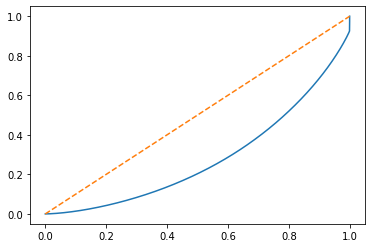

In [65]:
Vt = Base.groupby(['client_id']).price.sum()
n = len(Vt)
lorenz = np.cumsum(np.sort(Vt)) / Vt.sum()
lorenz = np.append([0],lorenz) 
bins = np.linspace(0.0,1.0)
xaxis = np.linspace(0,1, len(lorenz)) 
pp.plot(xaxis,lorenz)
pp.plot(bins,bins,'--')
pp.show()

In [66]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n  
S = 0.5 - AUC 
gini = 2*S
gini

0.44044416160208444

- Les 20% des clients qui achètent le moins pèsent pour moins de 10% dans le revenu global de la période.
- Les 20% des clients qui achètent le plus pèsent pour plus de 40% dans le revenu global de la période.
- L'indice de Gini est un indicateur d'égalité. Il est compris entre 0 et 1. Plus il est proche de 0, plus la population est répartie équitablement. Un indice de Gini de 0.44 démontre une répartition des ventes totales par client inégale.
<br/>
<br/> Nous allons analyser le top 10 des clients sur la période pour contrôler s'il y a des clients VIP.

In [67]:
Vta = np.sort(Vt)
print (Vta[np.argsort(Vta)[-10:]])

[  2313.54   2332.08   2346.34   2366.2    2406.17   2424.5   52720.68
  69382.17 137151.48 150729.07]


In [68]:
TopClient = Base.groupby(['client_id'],as_index = False ).price.sum()
TopClient = TopClient[TopClient['price'] > 50000]
TopClient.head()

,client_id,price
677,c_1609,150729.07
2723,c_3454,52720.68
4387,c_4958,137151.48
6336,c_6714,69382.17


Nous constatons que 4 clients ressortent comme étant importants :
- c_1609 pour 150 729 euros d'achat
- c_4958 pour 137 151 euros d'achat
- c_6714 pour 69 382 euros d'achat
- c_3454 pour 52 720 euros d'achat
<br/>
<br/> Ces clients composent 7% du CA de la période (400 000 / 5 800 00).

[Retour au Sommaire](#Sommaire)

## III - Corrélations <a id="Titre4"></a>
Nous allons maintenant analyser s'il y a des corrélations entre les différentes variables de notre Dataframe.

### A - 2 variables qualitatives : Test du KHIDEUX <a id="Titre4A"></a>

Etudier une corrélation entre deux variables qualitatives revient donc à comparer les  nij  avec les fi×nj . Les nij , ce sont les nombres qui sont dans le tableau de contingence (en dehors des colonnes TOTAL). On doit donc créer un autre tableau qui aurait la même forme que le tableau de contingence, mais qui contiendrait plutôt les fi×nj : la table indep. Le test de KHIDEUX revient à comparer ces deux tableaux.
La manière la plus visuelle de présenter les résultats de préparer une carte de chaleur ou tableau des effectifs colorés.

#### 1 - Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?

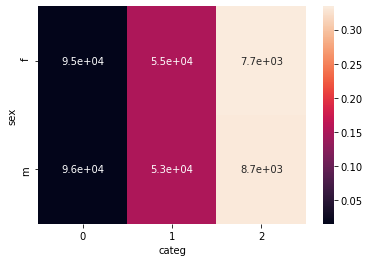

In [69]:
X = "sex"
Y = "categ"

cont = Base[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total") 
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(Base)
indep = tx.dot(ty) / n
c = cont.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sb.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
pp.show()

Nous constatons que :
- La répartiton h/f est quasi parfaite pour la catégorie 0;
- La corrélation entre le sexe et les catégories sont légèrement moindres pour les catégories 1 et 2. Pour la catégorie 1, cette différence n'est pas flagrante mais les femmes qui achètent légèrement moins de produits au total que les hommes achètent plus de produits issus de cette catégorie. Pour la catégorie 2, il existe une légère tendance en faveur des hommes.
<br/n> En effet, ils achètent sensiblement plus que les femmes mais ce n'est pas suffisant pour dire qu'il y a une corrélation entre la catégorie 2 et les hommes.

#### 2 - Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ?

Pour se faire et afin d'améliorer la lisibilité de nos résultats, nous allons utiliser nos tranches d'âge et analyser si une corrélation existe avec les catégories. Nous avions posé comme hypothèse que les personnes de moins de 30 ans privilégient les produits de la catégorie 2.

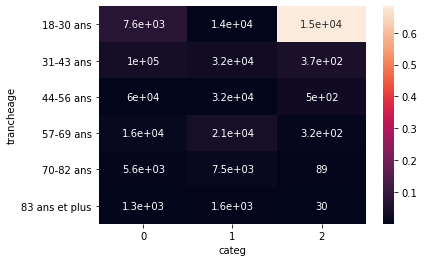

In [70]:
X = "trancheage"
Y = "categ"

cont = Base[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(Base)
indep = tx.dot(ty) / n
c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sb.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
pp.show()

Nous constatons qu'il existe une corrélation entre les moins de 30 ans et la catégorie 2.
Notre hypothèse est validée grâce au test de KHIDEUX.

[Retour au Sommaire](#Sommaire)

### B - 1 variable qualitative et 1 variable quantitative : ANOVA <a id="Titre4B"></a>

Etudier une corrélation entre une variable qualitative et une variable quantitative revient à effectuer une regression linéaire et de comparer les valeurs obtenues avec une courbe de type y = ax + b. Visuellement, une variable peut sembler être corrélée ou non. Nous calculons alors l'eta_carré qui permet de savoir si la variable quantitative est corrélée à la variable qualitative. Cet indicateur doit être inclus entre 0 et 1 : 0 étant une valeur fortement corrélée et 1 absolument pas corrélée.

#### Y a-t-il une corrélation entre l'âge des clients et le montant des ventes ?

Pour se faire et afin d'améliorer la lisibilité de nos résultats, nous allons utiliser nos tranches d'âge et analyser si une corrélation existe avec le chiffre d'affaires constaté.

Text(0.5, 1.0, "Evolution du chiffre d'affaires par tranche d'âge")

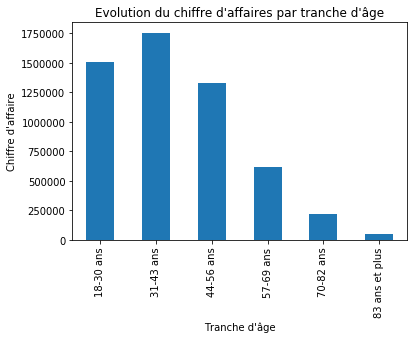

In [71]:
Trancheprix = Base.groupby(['trancheage'],as_index = True ).price.sum()
Trancheprix.plot(kind = 'bar')
pp.xlabel("Tranche d'âge")
pp.ylabel("Chiffre d'affaire")
pp.title("Evolution du chiffre d'affaires par tranche d'âge")

In [72]:
X = "trancheage" # qualitative
Y = "price" # quantitative

eta_squared(Base[X],Base[Y])

0.23383505985834913

- Notre repère semble tracer une droite partant de 170 000 euros environ pour la tranche d'age 18-30 ans jusqu'à presque 0 pour la tranche d'âge 83 ans et plus.
- Notre eta_carré est de 0.23 ce qui montre que nos variables ne sont pas parfaitement corrélées mais que plus l'on est jeune, plus l'on achète de produits de Restez Livres.  

[Retour au Sommaire](#Sommaire)

### C - 2 variables quantitatives : Coefficient de Pierson <a id="Titre4C"></a>

Etudier une corrélation entre deux variables quantitatives revient à effectuer une regression linéaire et de comparer les valeurs obtenues avec une courbe de type y = ax + b. Visuellement, une variable peut sembler être corrélée ou non. Nous calculons alors le coefficient de Pierson qui permet de savoir si deux variables quantitatives sont corrélées. Cet indicateur doit être inclus entre -1 et 1 : 0 étant une valeur non corrélée, 1 une valeur corrélée (les deux variables augmentent ensemble) et -1 une valeur corrélée (Si une variable augmente, la seconde diminue).

#### 1 - Y a-t-il une corrélation entre l'âge des clients et le nombre de ventes ?

Text(0.5, 1.0, "Evolution du nombre de ventes en fonction de l'age des clients")

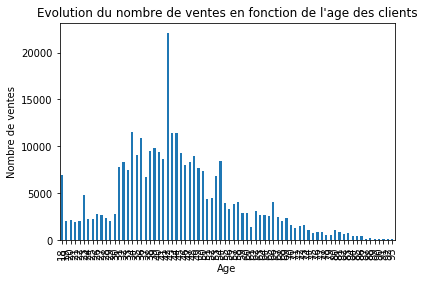

In [73]:
Ageprix = Base.groupby(['age'],as_index = True ).session_id.count()
Ageprix.plot(kind = 'bar')
pp.xlabel("Age")
pp.ylabel("Nombre de ventes")
pp.title("Evolution du nombre de ventes en fonction de l'age des clients")

In [74]:
Ageprix = Base.groupby(['age'],as_index = False ).session_id.count()
print(st.pearsonr(Ageprix["age"],Ageprix["session_id"])[0])

-0.5317985753516941


- Le pic de consommation en terme de nombre de ventes se trouve entre 30 et 55 ans.
- Les moins de 30 ans achètent moins mais ciblent plus les produits de catégories 2 qui sont plus chers.
- Le coefficient de Pierson est de -0.53 ce qui ne nous permet pas de conclure sur une corrélation entre ces variables.

#### 2 - Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen ?

Text(0.5, 1.0, "Evolution du panier moyen en fonction de l'age des clients")

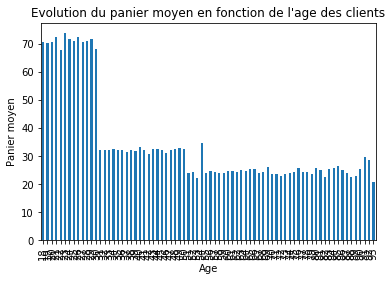

In [75]:
Panier_moyen1 = Base.groupby(['age','session_id'],as_index = False ).price.sum()
Panier_moyen = Panier_moyen1.groupby(['age'],as_index = True ).price.mean()
Panier_moyen.plot(kind = 'bar')
pp.xlabel("Age")
pp.ylabel("Panier moyen")
pp.title("Evolution du panier moyen en fonction de l'age des clients")

In [76]:
Panier_moyen = Panier_moyen1.groupby(['age'],as_index = False ).price.mean()
print(st.pearsonr(Panier_moyen["age"],Panier_moyen["price"])[0])

-0.7510836350498594


- Les moins de 30 ans ont un panier moyen supérieur aux autres tranches d'âge.
- Après 30 ans, le panier moyen est stable.
- Le coefficient de Pierson est de -0.75 ce qui signifie qu'il y a une légère corrélation entre l'âge et le panier moyen. Cette corrélation est inverse car le coefficient est négatif (plus l'âge augmente, plus le panier moyen diminue).

[Retour au Sommaire](#Sommaire)